In [27]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Bidirectional, GRU, Dropout, Dense, Activation

In [28]:
print(f"pandas=={pd.__version__}")
print(f"numpy=={np.__version__}")
print(f"sklearn=={sklearn.__version__}")
print(f"tensorflow=={tf.__version__}")
print(f"keras=={keras.__version__}")

pandas==1.3.5
numpy==1.21.6
sklearn==1.0.2
tensorflow==2.9.2
keras==2.9.0


In [29]:
csv_path = "https://raw.githubusercontent.com/curiousily/Deep-Learning-For-Hackers/master/data/3.stock-prediction/BTC-USD.csv"
df = pd.read_csv(csv_path, parse_dates=['Date'])
df = df.sort_values('Date')

In [30]:
scaler = MinMaxScaler()

close_price = df.Close.values.reshape(-1, 1)

scaled_close = scaler.fit_transform(close_price)

In [31]:
scaled_close = scaled_close[~np.isnan(scaled_close)]
scaled_close = scaled_close.reshape(-1, 1)

In [32]:
SEQ_LEN = 100

def to_sequences(data, seq_len):
    d = []

    for index in range(len(data) - seq_len):
        d.append(data[index: index + seq_len])

    return np.array(d)

def preprocess(data_raw, seq_len, train_split):

    data = to_sequences(data_raw, seq_len)

    num_train = int(train_split * data.shape[0])

    X_train = data[:num_train, :-1, :]
    y_train = data[:num_train, -1, :]

    X_test = data[num_train:, :-1, :]
    y_test = data[num_train:, -1, :]

    return X_train, y_train, X_test, y_test


X_train, y_train, X_test, y_test =\
 preprocess(scaled_close, SEQ_LEN, train_split = 0.95)

In [33]:
DROPOUT = 0.2
WINDOW_SIZE = SEQ_LEN - 1

model = keras.Sequential()

model.add(Bidirectional(
  GRU(WINDOW_SIZE, return_sequences=True),
  input_shape=(WINDOW_SIZE, X_train.shape[-1])
))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(
  GRU((WINDOW_SIZE * 2), return_sequences=True)
))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(
  GRU(WINDOW_SIZE, return_sequences=False)
))

model.add(Dense(units=1))

model.add(Activation('linear'))

In [34]:
BATCH_SIZE = 64

model.compile(
    loss='mean_squared_error',
    optimizer='adam'
)

history = model.fit(
    X_train,
    y_train,
    epochs=30,
    batch_size=BATCH_SIZE,
    shuffle=False,
    validation_split=0.1
)

Epoch 1/30
42/42 [==============================] - 13s 85ms/step - loss: 5.2530e-04 - val_loss: 0.0254
Epoch 2/30
42/42 [==============================] - 2s 40ms/step - loss: 0.0074 - val_loss: 0.0499
Epoch 3/30
42/42 [==============================] - 2s 39ms/step - loss: 0.0109 - val_loss: 0.0261
Epoch 4/30
42/42 [==============================] - 2s 39ms/step - loss: 0.0032 - val_loss: 0.0212
Epoch 5/30
42/42 [==============================] - 2s 39ms/step - loss: 0.0184 - val_loss: 0.0780
Epoch 6/30
42/42 [==============================] - 2s 39ms/step - loss: 0.0073 - val_loss: 0.0362
Epoch 7/30
42/42 [==============================] - 2s 39ms/step - loss: 0.0078 - val_loss: 0.0121
Epoch 8/30
42/42 [==============================] - 2s 39ms/step - loss: 0.0194 - val_loss: 0.0812
Epoch 9/30
42/42 [==============================] - 2s 39ms/step - loss: 0.0099 - val_loss: 0.0184
Epoch 10/30
42/42 [==============================] - 2s 39ms/step - loss: 0.0066 - val_loss: 6.2443e-04


In [35]:
y_hat = model.predict(X_test)

5/5 [==============================] - 2s 14ms/step


In [36]:
y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)

In [37]:
model.evaluate(X_test, y_test)

5/5 [==============================] - 0s 20ms/step - loss: 1.4202e-04


0.0001420210173819214

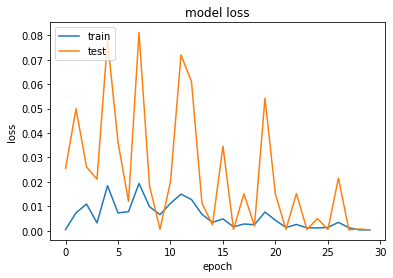

In [38]:
import matplotlib.pyplot as plt
from matplotlib import rc

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

5/5 [==============================] - 0s 17ms/step


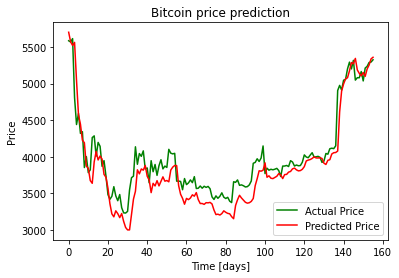

In [39]:
y_hat = model.predict(X_test)

y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)
 
plt.plot(y_test_inverse, label="Actual Price", color='green')
plt.plot(y_hat_inverse, label="Predicted Price", color='red')
 
plt.title('Bitcoin price prediction')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.legend(loc='best')
 
plt.show();